# **Telco Customer Churn Prediction**

*M. Ruben (June 2019)*
***
<div style="text-align: justify">The objective of this notebook is to build a model that can predict which customer will churn. [Churn rate](https://en.wikipedia.org/wiki/Churn_rate), as defined in wikipedia, is a measure of the number of individuals or items moving out of a collective group over a specific period. Therefore, customers who churns are individuals who are no longer using the service of a business. The dataset which will be used in this notebook is a telecommunications company's anonymous customer data.</div>
***
**Acknowledgement**: The original dataset can be found in [this link](https://www.kaggle.com/blastchar/telco-customer-churn). 
***
# Contents<a id = 'TOC'></a>
- **[1. Modules](#1)** 
- **[2. Exploratory Data Analysis](#2)**
    * [**2.1** *customerID*](#2.1)  
    * [**2.2** *gender*](#2.2)
    * [**2.3** *SeniorCitizen*](#2.3)
    * [**2.4** *Partner*](#2.4)
    * [**2.5** *Dependents*](#2.5)
    * [**2.6** *tenure*](#2.6)
    * [**2.7** *PhoneService*](#2.7)
    * [**2.8** *MultipleLines*](#2.8)
    * [**2.9** *InternetService*](#2.9)
    * [**2.10** *OnlineSecurity*](#2.10)
    * [**2.11** *OnlineBackup*](#2.11)
    * [**2.12** *DeviceProtection*](#2.12)
    * [**2.13** *TechSupport*](#2.13)
    * [**2.14** *StreamingTV*](#2.14)
    * [**2.15** *StreamingMovies*](#2.15)
    * [**2.16** *Contract*](#2.16)
    * [**2.17** *PaperlessBilling*](#2.17)
    * [**2.18** *PaymentMethod*](#2.18)
    * [**2.19** *MonthlyCharges*](#2.19)
    * [**2.20** *TotalCharges*](#2.20)
    <br><br>  
- **[3. One Hot Encoding](#3)** 
- **[4. Univariate Selection](#4)**
- **[5. Train-Test Split](#5)**
- **[6. Oversampling (SMOTE)](#6)**
- **[7. XGBoost](#7)**
- **[8. Concluding Remarks](#8)**

# 1. Modules <a id = '1'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

[Back to Table of Content](#TOC)

# 2. Exploratory Data Analysis <a id = '2'></a>

This section will focus on the process of exploring the dataset in order to gain a better understanding of the problem. First, we will import the dataset using pandas.

In [2]:
# Import dataset
telco_df = pd.read_csv('CSV/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Show head
display(telco_df.head())

# Show shape
print('\n* Shape of the dataframe is', np.shape(telco_df))

# list all columns
cols = telco_df.columns

# list all columns which are numeric
num_cols = telco_df._get_numeric_data().columns

# list all columns which are categorical
cat_cols = list(set(cols)-set(num_cols))

# print out number of numerical columns and categorical columns
print('* Number of numerical columns : ', len(num_cols), 'columns')
print('* Number of categorical columns : ', len(cat_cols), 'columns')

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ...  DeviceProtection  \
0  No phone service             DSL             No  ...                No   
1                No             DSL            Yes  ...               Yes   
2                No             DSL            Yes  ...                No   
3  No phone service             DSL            Yes  ...               Yes   
4                No     Fiber optic             No  ...                No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]


* Shape of the dataframe is (7043, 21)
* Number of numerical columns :  3 columns
* Number of categorical columns :  18 columns


From the cell above we can see that the original dataframe consists of 21 types of information about 7043 customers. The informations available are customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetServcie, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, Payment Method, MonthlyCharges, TotalCharges and finally the target which is Churn. Out of these, 3 columns are of numerical data and 18 columns are of categorical data. Below we will look at each one of the feature columns seperately.

[Back to Table of Content](#TOC)

***
**2.1** *customerID* <a id = '2.1'></a>
***
'customerID' refers to the ID associated with each particular customer.

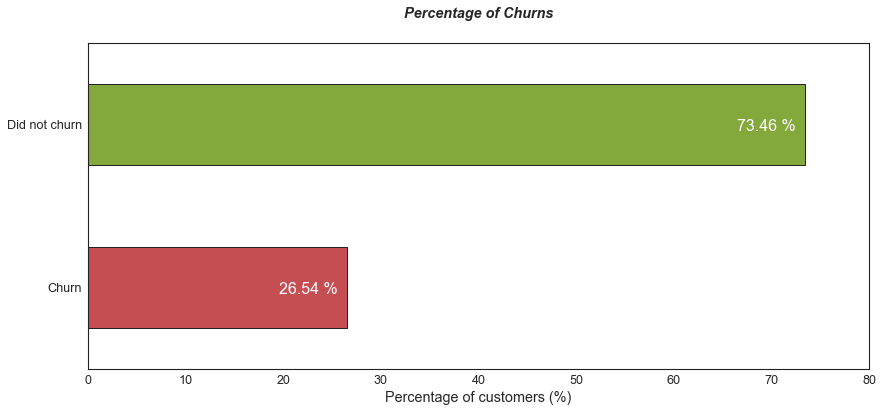

In [3]:
# Amount of customer who churned
tot_churn = len(telco_df.Churn[telco_df.Churn == 'Yes'])
pct_tot_churn = tot_churn/len(telco_df.Churn)*100

# Amount of customer who did not churned
tot_not_churn = len(telco_df.Churn[telco_df.Churn == 'No'])
pct_tot_not_churn = tot_not_churn/len(telco_df.Churn)*100

# Create dataframe for bar plot
data = {'Churn': [pct_tot_churn, pct_tot_not_churn]}
churn_status_df = pd.DataFrame(data, index = ['Churn', 'Did not churn'])

# Create bar plot to show percentage of customer who churned and didn't
% matplotlib inline
ax = churn_status_df.plot(kind='barh', figsize = (14,6), color = ['rgbkymc']
                          , edgecolor = 'k', linewidth = 1)

# Grid axes
ax.grid(None)

# Plot border
for spine in ax.spines:
    ax.spines[spine].set_color('k')

# Annotate percentage value
for i, v in enumerate(np.round(churn_status_df.values, 2)):
    ax.text(v - 7, i - 0.04, str(float(v))+' %', color='white', fontsize = 16)
    
# Remove legend
ax.get_legend().remove()

# set title
ax.set_title('Percentage of Churns', pad = 25, fontweight = 'bold', fontstyle = 'italic');

# set xlabel
ax.set_xlabel('Percentage of customers (%)');

# Set tick
ax.set_xticks(np.arange(0, 90, 10));

As can be seen in the figure above, only 26.54 % of the customers actually churned. This means that the target classes would not be represented equally, therefore the data is imbalanced. Steps taken to counteract this problem will be shown in later sections.

[Back to Table of Content](#TOC)

***
**2.2** *gender* <a id = '2.2'></a>
***
The 'gender' column shows wether the customer of male or a female. The code below will show the gender distribution of customers who churned.

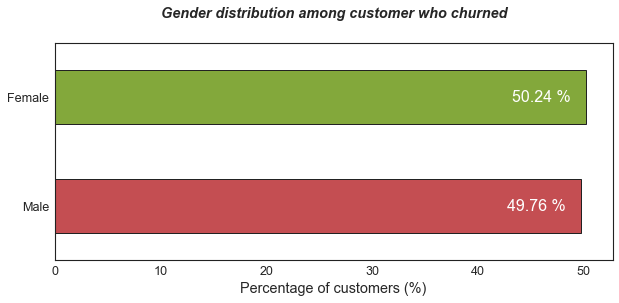

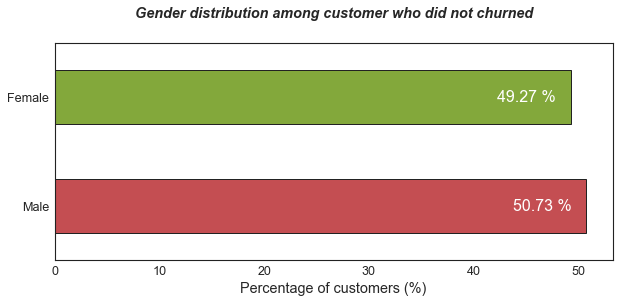

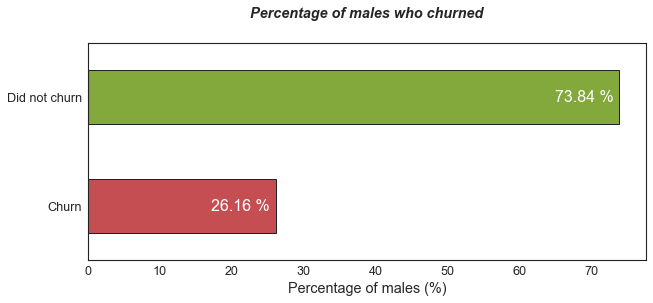

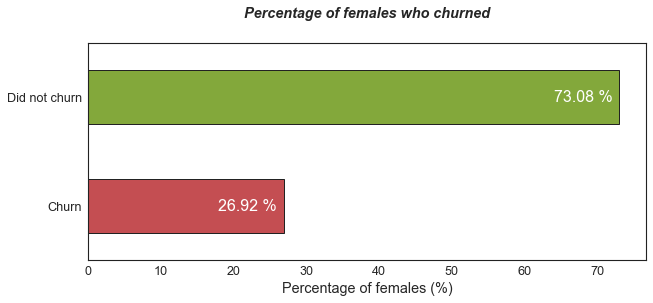

In [4]:
## Gender of customer who churned
churn_male = telco_df[(telco_df.Churn == 'Yes') & (telco_df.gender == 'Male')]
tot_churn_male = len(churn_male.index)
pct_churn_male = tot_churn_male/tot_churn*100
churn_female = telco_df[(telco_df.Churn == 'Yes') & (telco_df.gender == 'Female')]
tot_churn_female = len(churn_female.index)
pct_churn_female = tot_churn_female/tot_churn*100

# Create dataframe for bar plot
data = {'Gender': [pct_churn_male, pct_churn_female]}
churn_gender_df = pd.DataFrame(data, index = ['Male', 'Female'])

# Create bar plot to show percentage of customer who churned and didn't
% matplotlib inline
ax1 = churn_gender_df.plot(kind='barh', figsize = (10,4), color = ['rgbkymc1']
                          , edgecolor = 'k', linewidth = 1)

# Grid axes
ax1.grid(None)

# Plot border
for spine in ax.spines:
    ax1.spines[spine].set_color('k')

# Annotate percentage value
for i, v in enumerate(np.round(churn_gender_df.values, 2)):
    ax1.text(v - 7, i - 0.04, str(float(v))+' %', color='white', fontsize = 16)
    
# Remove legend
ax1.get_legend().remove()

# set title
ax1.set_title('Gender distribution among customer who churned', pad = 25, fontweight = 'bold', fontstyle = 'italic');

# set xlabel
ax1.set_xlabel('Percentage of customers (%)');
plt.show()

## Gender of customer who did not churned
not_churn_male = telco_df[(telco_df.Churn == 'No') & (telco_df.gender == 'Male')]
tot_not_churn_male = len(not_churn_male.index)
pct_not_churn_male = tot_not_churn_male/tot_not_churn*100
not_churn_female = telco_df[(telco_df.Churn == 'No') & (telco_df.gender == 'Female')]
tot_not_churn_female = len(not_churn_female.index)
pct_not_churn_female = tot_not_churn_female/tot_not_churn*100

# Create dataframe for bar plot
data = {'Gender': [pct_not_churn_male, pct_not_churn_female]}
not_churn_gender_df = pd.DataFrame(data, index = ['Male', 'Female'])

# Create bar plot to show percentage of customer who churned and didn't
% matplotlib inline
ax2 = not_churn_gender_df.plot(kind='barh', figsize = (10,4), color = ['rgbkymc1']
                              , edgecolor = 'k', linewidth = 1)

# Grid axes
ax2.grid(None)

# Plot border
for spine in ax.spines:
    ax2.spines[spine].set_color('k')

# Annotate percentage value
for i, v in enumerate(np.round(not_churn_gender_df.values, 2)):
    ax2.text(v - 7, i - 0.04, str(float(v))+' %', color='white', fontsize = 16)
    
# Remove legend
ax2.get_legend().remove()

# set title
ax2.set_title('Gender distribution among customer who did not churned', pad = 25, fontweight = 'bold', fontstyle = 'italic');

# set xlabel
ax2.set_xlabel('Percentage of customers (%)');
print('\n\n')
plt.show()

## Percentage of males who churned
tot_male = len(telco_df[telco_df.gender == 'Male'].index)
pct_male_churn = tot_churn_male/tot_male*100
pct_male_not_churn = tot_not_churn_male/tot_male*100

# Create dataframe for bar plot
data = {'Churn': [pct_male_churn, pct_male_not_churn]}
male_churn_df = pd.DataFrame(data, index = ['Churn', 'Did not churn'])

# Create bar plot to show percentage of customer who churned and didn't
% matplotlib inline
ax3 = male_churn_df.plot(kind='barh', figsize = (10,4), color = ['rgbkymc1']
                          , edgecolor = 'k', linewidth = 1)

# Grid axes
ax3.grid(None)

# Plot border
for spine in ax.spines:
    ax3.spines[spine].set_color('k')

# Annotate percentage value
for i, v in enumerate(np.round(male_churn_df.values, 2)):
    ax3.text(v - 9, i - 0.04, str(float(v))+' %', color='white', fontsize = 16)
    
# Remove legend
ax3.get_legend().remove()

# set title
ax3.set_title('Percentage of males who churned', pad = 25, fontweight = 'bold', fontstyle = 'italic');

# set xlabel
ax3.set_xlabel('Percentage of males (%)');
print('\n\n')
plt.show()

## Percentage of females who churned
tot_female = len(telco_df[telco_df.gender == 'Female'].index)
pct_female_churn = tot_churn_female/tot_female*100
pct_female_not_churn = tot_not_churn_female/tot_female*100

# Create dataframe for bar plot
data = {'Churn': [pct_female_churn, pct_female_not_churn]}
female_churn_df = pd.DataFrame(data, index = ['Churn', 'Did not churn'])

# Create bar plot to show percentage of customer who churned and didn't
% matplotlib inline
ax4 = female_churn_df.plot(kind='barh', figsize = (10,4), color = ['rgbkymc1']
                          , edgecolor = 'k', linewidth = 1)

# Grid axes
ax4.grid(None)

# Plot border
for spine in ax.spines:
    ax4.spines[spine].set_color('k')

# Annotate percentage value
for i, v in enumerate(np.round(female_churn_df.values, 2)):
    ax4.text(v - 9, i - 0.04, str(float(v))+' %', color='white', fontsize = 16)
    
# Remove legend
ax4.get_legend().remove()

# set title
ax4.set_title('Percentage of females who churned', pad = 25, fontweight = 'bold', fontstyle = 'italic');

# set xlabel
ax4.set_xlabel('Percentage of females (%)');
print('\n\n')
plt.show()

* There does not seem to be any direct relationship between the gender of the customer and the probability of churning. 
* The gender distribution among customers who churned are about the same at 50.24 % and 49.76 % for males and females, respectively. 
* In addition the percentage of males and females who churned are also about the same at 73.84 % and 73.08 %, respectively.

[Back to Table of Content](#TOC)

***
**2.3** *SeniorCitizen* <a id = '2.3'></a>
***
The 'SeniorCitizen' column shows whether the customer is a senior citizen or not, with the value '1' indicating yes while the value '0' indicating no. The code below calculates the churn rate of senior citizens vs. non-senior citizen.

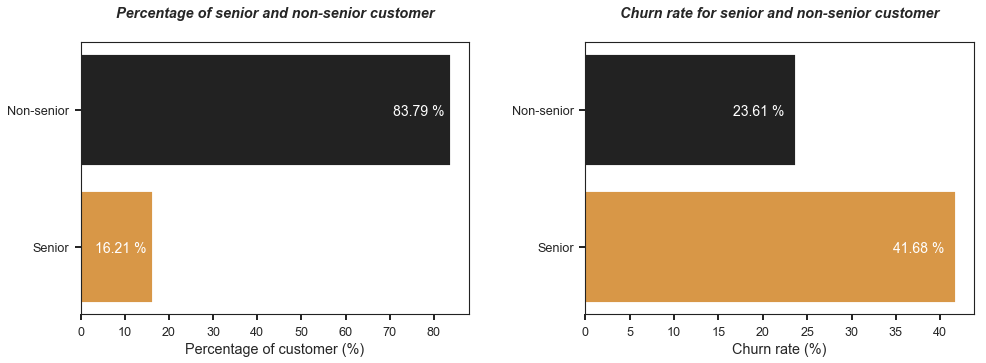

In [5]:
# Churn rate of senior 
tot_sc_churn = len(telco_df[(telco_df.SeniorCitizen == 1) & (telco_df.Churn == 'Yes')].index)
tot_sc = len(telco_df[(telco_df.SeniorCitizen == 1)].index)
pct_sc_churn = tot_sc_churn/tot_sc*100

# Churn rate of non-senior
tot_nsc_churn = len(telco_df[(telco_df.SeniorCitizen == 0) & (telco_df.Churn == 'Yes')].index)
tot_nsc = len(telco_df[(telco_df.SeniorCitizen == 0)].index)
pct_nsc_churn = tot_nsc_churn/tot_nsc*100

# Percentage of customer who are senior citizen
pct_tot_sc = tot_sc/len(telco_df.index)*100
pct_tot_nsc = tot_nsc/len(telco_df.index)*100

# Plot percentage of customer who are senior
% matplotlib inline
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
x = [pct_tot_sc, pct_tot_nsc]
y = ['Senior', 'Non-senior']
y_pos = np.arange(len(y))
ax[0].barh(y_pos, x)
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(y)
ax[0].grid(None)
ax[0].get_children()[0].set_color('#d89747')
ax[0].get_children()[1].set_color('k')
ax[0].tick_params(length = 6, width = 2)
ax[0].set_title('Percentage of senior and non-senior customer', pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[0].set_xlabel('Percentage of customer (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[0].text(v - 13, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[0].spines:
    ax[0].spines[spine].set_color('k') # Plot black border

# Plot churn rate of customer who are senior
x = [pct_sc_churn, pct_nsc_churn]
y = ['Senior', 'Non-senior']
y_pos = np.arange(len(y))
ax[1].barh(y_pos, x)
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(y)
ax[1].grid(None)
ax[1].get_children()[0].set_color('#d89747')
ax[1].get_children()[1].set_color('k')
ax[1].tick_params(length = 6, width = 2)
ax[1].set_title('Churn rate for senior and non-senior customer', pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[1].set_xlabel('Churn rate (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[1].text(v - 7, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[1].spines:
    ax[1].spines[spine].set_color('k') # Plot black border

# adjust white space between subplots
plt.subplots_adjust(wspace = 0.3)

# show plots
plt.show()

* Only 16.21 % of the customers are senior citizen, compared to 83.79 % who are non-senior citizen.
* However, the churn rate for senior citizen are higher for senior citizen compared to non-senior citizen, at 41.68 % and 23.61 % respectively.  

[Back to Table of Content](#TOC)

***
**2.4** *Partner* <a id = '2.4'></a>
***
The 'Partner' column shows whether the customer has a partner or not. The code below calculates the churn rate of customer with partner vs. customer without partner.

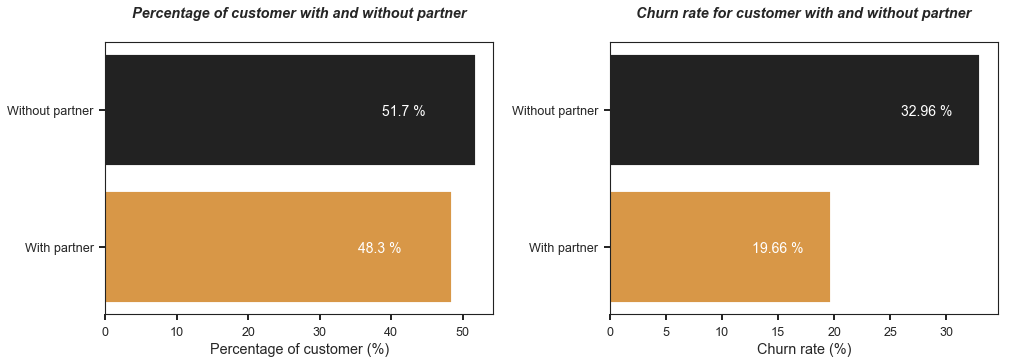

In [6]:
# Churn rate of customer with partner 
tot_wp_churn = len(telco_df[(telco_df.Partner == 'Yes') & (telco_df.Churn == 'Yes')].index)
tot_wp = len(telco_df[(telco_df.Partner == 'Yes')].index)
pct_wp_churn = tot_wp_churn/tot_wp*100

# Churn rate of customer without partner
tot_wop_churn = len(telco_df[(telco_df.Partner == 'No') & (telco_df.Churn == 'Yes')].index)
tot_wop = len(telco_df[(telco_df.Partner == 'No')].index)
pct_wop_churn = tot_wop_churn/tot_wop*100

# Percentage of customer who are with and without partner
pct_tot_wp = tot_wp/len(telco_df.index)*100
pct_tot_wop = tot_wop/len(telco_df.index)*100

# Plot percentage of customer who are with and without partner
% matplotlib inline
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
x = [pct_tot_wp, pct_tot_wop]
y = ['With partner', 'Without partner']
y_pos = np.arange(len(y))
ax[0].barh(y_pos, x)
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(y)
ax[0].grid(None)
ax[0].get_children()[0].set_color('#d89747')
ax[0].get_children()[1].set_color('k')
ax[0].tick_params(length = 6, width = 2)
ax[0].set_title('Percentage of customer with and without partner', pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[0].set_xlabel('Percentage of customer (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[0].text(v - 13, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[0].spines:
    ax[0].spines[spine].set_color('k') # Plot black border

# Plot churn of customer who are with and without partner
x = [pct_wp_churn, pct_wop_churn]
y = ['With partner', 'Without partner']
y_pos = np.arange(len(y))
ax[1].barh(y_pos, x)
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(y)
ax[1].grid(None)
ax[1].get_children()[0].set_color('#d89747')
ax[1].get_children()[1].set_color('k')
ax[1].tick_params(length = 6, width = 2)
ax[1].set_title('Churn rate for customer with and without partner', pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[1].set_xlabel('Churn rate (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[1].text(v - 7, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[1].spines:
    ax[1].spines[spine].set_color('k') # Plot black border

# adjust white space between subplots
plt.subplots_adjust(wspace = 0.3)

# show plots
plt.show()

* The distribution of customer with and without partner are about the same at 48.3 % and 51.7 % respectively.
* The churn rate for customer without partner is 13.3 % higher than those with partner.

[Back to Table of Content](#TOC)

***
**2.5** *Dependents* <a id = '2.5'></a>
***
The 'Dependents' column shows whether the customer has dependents or not. The code below calculates the churn rate of customer with dependents vs. customer without dependents.

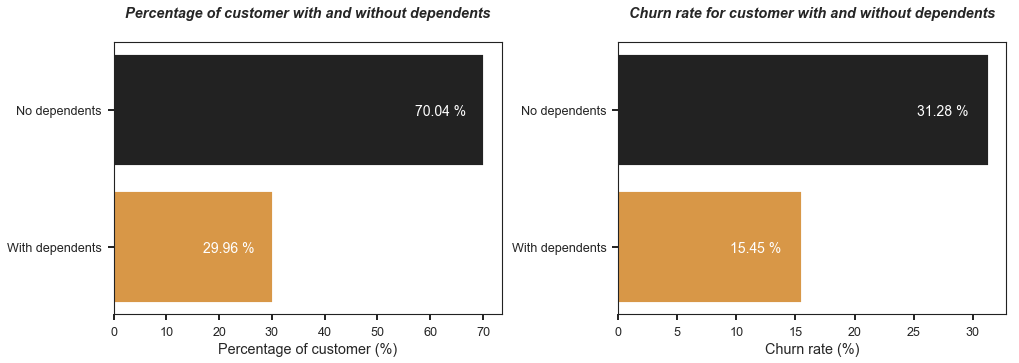

In [7]:
# Churn rate of customer with dependents 
tot_wd_churn = len(telco_df[(telco_df.Dependents == 'Yes') & (telco_df.Churn == 'Yes')].index)
tot_wd = len(telco_df[(telco_df.Dependents == 'Yes')].index)
pct_wd_churn = tot_wd_churn/tot_wd*100

# Churn rate of customer without dependents
tot_wod_churn = len(telco_df[(telco_df.Dependents == 'No') & (telco_df.Churn == 'Yes')].index)
tot_wod = len(telco_df[(telco_df.Dependents == 'No')].index)
pct_wod_churn = tot_wod_churn/tot_wod*100

# Percentage of customer who are with and without dependents
pct_tot_wd = tot_wd/len(telco_df.index)*100
pct_tot_wod = tot_wod/len(telco_df.index)*100

# Plot percentage of customer who are with and without dependents
% matplotlib inline
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
x = [pct_tot_wd, pct_tot_wod]
y = ['With dependents', 'No dependents']
y_pos = np.arange(len(y))
ax[0].barh(y_pos, x)
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(y)
ax[0].grid(None)
ax[0].get_children()[0].set_color('#d89747')
ax[0].get_children()[1].set_color('k')
ax[0].tick_params(length = 6, width = 2)
ax[0].set_title('Percentage of customer with and without dependents', pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[0].set_xlabel('Percentage of customer (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[0].text(v - 13, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[0].spines:
    ax[0].spines[spine].set_color('k') # Plot black border

# Plot churn of customer who are with and without dependents
x = [pct_wd_churn, pct_wod_churn]
y = ['With dependents', 'No dependents']
y_pos = np.arange(len(y))
ax[1].barh(y_pos, x)
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(y)
ax[1].grid(None)
ax[1].get_children()[0].set_color('#d89747')
ax[1].get_children()[1].set_color('k')
ax[1].tick_params(length = 6, width = 2)
ax[1].set_title('Churn rate for customer with and without dependents', pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[1].set_xlabel('Churn rate (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[1].text(v - 6, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[1].spines:
    ax[1].spines[spine].set_color('k') # Plot black border

# adjust white space between subplots
plt.subplots_adjust(wspace = 0.3)

# show plots
plt.show()

* There are less customer with dependents compared to without dependents at 29.96 % and 70.04 % respectively.
* However, the churn rate for customer without dependents more than doubles that of customer with no dependents at 31.28 % and 15.45 % respectively.

[Back to Table of Content](#TOC)

***
**2.6** *tenure* <a id = '2.6'></a>
***
The 'tenure' column shows the number of months the customer has stayed with the company.

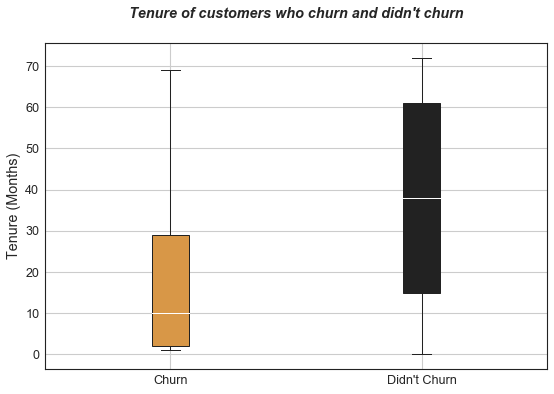

In [8]:
# get tenure vector of customer who churned
tenure_churn = telco_df[telco_df.Churn == 'Yes'].tenure.values

# get tenure vector of customer who didn't churned
tenure_not_churn = telco_df[telco_df.Churn == 'No'].tenure.values

# Plot a boxplot of tenure for customer who churn and didn't churn
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
tenure_bp = ax.boxplot([tenure_churn, tenure_not_churn], patch_artist = True)

# x ticks labels
ax.set_xticklabels(['Churn', 'Didn\'t Churn'])

# Change color for churn
tenure_bp['boxes'][0].set(facecolor = '#d89747')
tenure_bp['medians'][0].set(color = 'w')

# Change color for not churn
tenure_bp['boxes'][1].set(facecolor = 'k' )
tenure_bp['medians'][1].set(color = 'w')

# Plot black border
for spine in ax.spines:
    ax.spines[spine].set_color('k') 
    
# Label y-axis
ax.set_ylabel('Tenure (Months)')

# Set title
ax.set_title('Tenure of customers who churn and didn\'t churn', pad = 25, 
             fontweight = 'bold', fontstyle = 'italic')

plt.show()

* Both groups of customers have a quite similar overall range of tenure as evident by the lower and upper whisker of both groups.
* The majority of customer who churns tends to have shorter tenure compared to customers who didn't churn.
* This suggests that customers who have shorter tenure have a higher probability of churning.

[Back to Table of Content](#TOC)

***
**2.7** *PhoneService* <a id = '2.7'></a>
***
The 'tenure' column shows whether the customer has a phone service or not. 

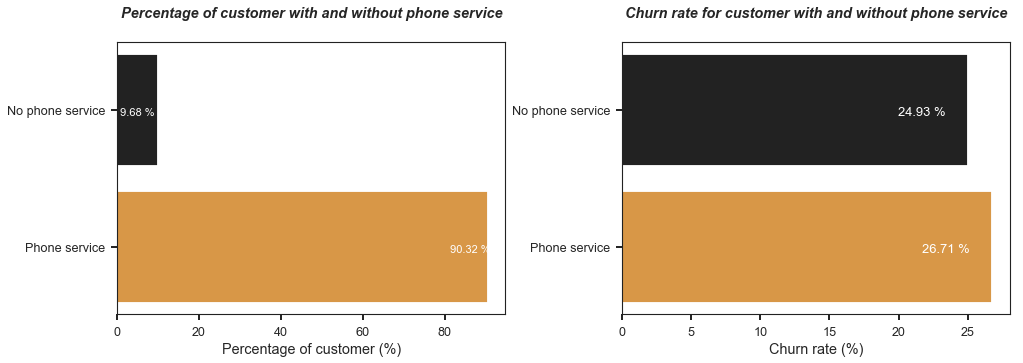

In [9]:
# Churn rate of customer with phone service 
tot_ps_churn = len(telco_df[(telco_df.PhoneService == 'Yes') & (telco_df.Churn == 'Yes')].index)
tot_ps = len(telco_df[(telco_df.PhoneService == 'Yes')].index)
pct_ps_churn = tot_ps_churn/tot_ps*100

# Churn rate of customer without phone service
tot_wps_churn = len(telco_df[(telco_df.PhoneService == 'No') & (telco_df.Churn == 'Yes')].index)
tot_wps = len(telco_df[(telco_df.PhoneService == 'No')].index)
pct_wps_churn = tot_wps_churn/tot_wps*100

# Percentage of customer who are with and without phone service
pct_tot_ps = tot_ps/len(telco_df.index)*100
pct_tot_wps = tot_wps/len(telco_df.index)*100

# Plot percentage of customer who are with and without phone service
% matplotlib inline
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
x = [pct_tot_ps, pct_tot_wps]
y = ['Phone service', 'No phone service']
y_pos = np.arange(len(y))
ax[0].barh(y_pos, x)
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(y)
ax[0].grid(None)
ax[0].get_children()[0].set_color('#d89747')
ax[0].get_children()[1].set_color('k')
ax[0].tick_params(length = 6, width = 2)
ax[0].set_title('Percentage of customer with and without phone service', 
                pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[0].set_xlabel('Percentage of customer (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[0].text(v - 9, i - 0.04, str(float(v))+' %', color='white', fontsize = 11) # Annotate
for spine in ax[0].spines:
    ax[0].spines[spine].set_color('k') # Plot black border

# Plot churn of customer who are with and without phone service
x = [pct_ps_churn, pct_wps_churn]
y = ['Phone service', 'No phone service']
y_pos = np.arange(len(y))
ax[1].barh(y_pos, x)
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(y)
ax[1].grid(None)
ax[1].get_children()[0].set_color('#d89747')
ax[1].get_children()[1].set_color('k')
ax[1].tick_params(length = 6, width = 2)
ax[1].set_title('Churn rate for customer with and without phone service', 
                pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[1].set_xlabel('Churn rate (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[1].text(v - 5, i - 0.04, str(float(v))+' %', color='white', fontsize = 13) # Annotate
for spine in ax[1].spines:
    ax[1].spines[spine].set_color('k') # Plot black border

# adjust white space between subplots
plt.subplots_adjust(wspace = 0.3)

# show plots
plt.show()

* Most of the customers have phone service at 90.32 % out of all customers having phone service
* However, the churn rate is about the same for both groups.
* This feature most likely doesn't directly affect the wether the customer will churn or not.

[Back to Table of Content](#TOC)

***
**2.8** *MultipleLines* <a id = '2.8'></a>
***
The 'MultipleLines' column shows whether the customer has multiple lines (phone service) or not.

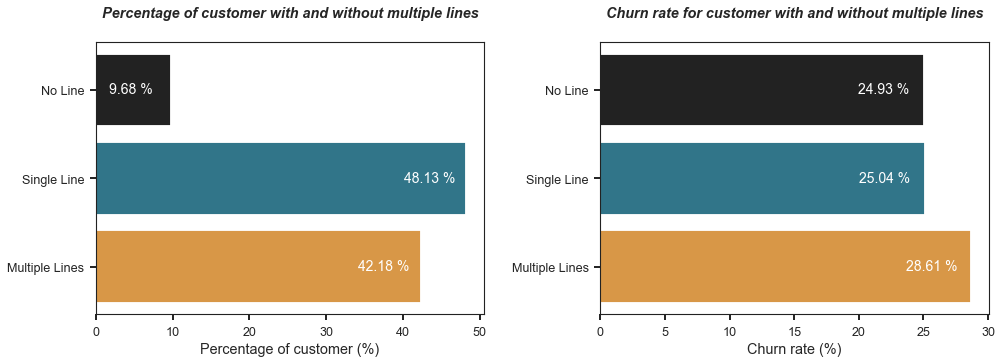

In [10]:
# Churn rate of customer with multiple lines 
tot_ml_churn = len(telco_df[(telco_df.MultipleLines == 'Yes') & (telco_df.Churn == 'Yes')].index)
tot_ml = len(telco_df[(telco_df.MultipleLines == 'Yes')].index)
pct_ml_churn = tot_ml_churn/tot_ml*100

# Churn rate of customer without single lines
tot_sl_churn = len(telco_df[(telco_df.MultipleLines == 'No') & (telco_df.Churn == 'Yes')].index)
tot_sl = len(telco_df[(telco_df.MultipleLines == 'No')].index)
pct_sl_churn = tot_sl_churn/tot_sl*100

# Churn rate of customer without no lines
tot_nl_churn = len(telco_df[(telco_df.MultipleLines == 'No phone service') & (telco_df.Churn == 'Yes')].index)
tot_nl = len(telco_df[(telco_df.MultipleLines == 'No phone service')].index)
pct_nl_churn = tot_nl_churn/tot_nl*100

# Percentage of customer who are with and without phone service
pct_tot_ml = tot_ml/len(telco_df.index)*100
pct_tot_sl = tot_sl/len(telco_df.index)*100
pct_tot_nl = tot_nl/len(telco_df.index)*100

# Plot percentage of customer who are with and without phone service
% matplotlib inline
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
x = [pct_tot_ml, pct_tot_sl, pct_tot_nl]
y = ['Multiple Lines', 'Single Line', 'No Line']
y_pos = np.arange(len(y))
ax[0].barh(y_pos, x)
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(y)
ax[0].grid(None)
ax[0].get_children()[0].set_color('#d89747')
ax[0].get_children()[1].set_color('#317589')
ax[0].get_children()[2].set_color('k')
ax[0].tick_params(length = 6, width = 2)
ax[0].set_title('Percentage of customer with and without multiple lines', 
                pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[0].set_xlabel('Percentage of customer (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[0].text(v - 8, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[0].spines:
    ax[0].spines[spine].set_color('k') # Plot black border

# Plot churn of customer who are with and without phone service
x = [pct_ml_churn, pct_sl_churn, pct_nl_churn]
y = ['Multiple Lines', 'Single Line', 'No Line']
y_pos = np.arange(len(y))
ax[1].barh(y_pos, x)
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(y)
ax[1].grid(None)
ax[1].get_children()[0].set_color('#d89747')
ax[1].get_children()[1].set_color('#317589')
ax[1].get_children()[2].set_color('k')
ax[1].tick_params(length = 6, width = 2)
ax[1].set_title('Churn rate for customer with and without multiple lines', 
                pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[1].set_xlabel('Churn rate (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[1].text(v - 5, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[1].spines:
    ax[1].spines[spine].set_color('k') # Plot black border

# adjust white space between subplots
plt.subplots_adjust(wspace = 0.3)

# show plots
plt.show()

* As was shown in the previous section, only 9.68 % of customer do not have any line while customers with single line are the slight majority at 48.13 %.
* The churn rate for all three groups are about the same. Customer with multiple lines have a slightly higher probability of churning compared to the other two groups. 

[Back to Table of Content](#TOC)

***
**2.9** *InternetService* <a id = '2.9'></a>
***
The 'InternetService' column shows customer’s internet service provider.

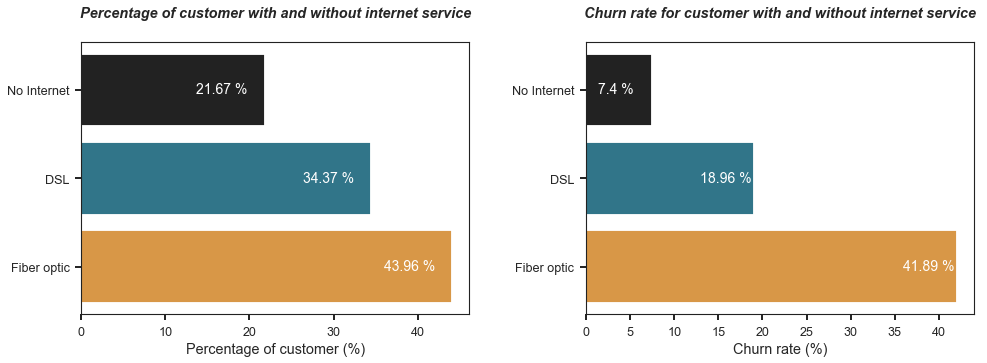

In [11]:
# Churn rate of customer with Fiber optic internet 
tot_fo_churn = len(telco_df[(telco_df.InternetService == 'Fiber optic') & (telco_df.Churn == 'Yes')].index)
tot_fo = len(telco_df[(telco_df.InternetService == 'Fiber optic')].index)
pct_fo_churn = tot_fo_churn/tot_fo*100

# Churn rate of customer with DSL internet
tot_DSL_churn = len(telco_df[(telco_df.InternetService == 'DSL') & (telco_df.Churn == 'Yes')].index)
tot_DSL = len(telco_df[(telco_df.InternetService == 'DSL')].index)
pct_DSL_churn = tot_DSL_churn/tot_DSL*100

# Churn rate of customer without no internet
tot_ni_churn = len(telco_df[(telco_df.InternetService == 'No') & (telco_df.Churn == 'Yes')].index)
tot_ni = len(telco_df[(telco_df.InternetService == 'No')].index)
pct_ni_churn = tot_ni_churn/tot_ni*100

# Percentage of customer who are with and without internet service
pct_tot_fo = tot_fo/len(telco_df.index)*100
pct_tot_DSL = tot_DSL/len(telco_df.index)*100
pct_tot_ni = tot_ni/len(telco_df.index)*100

# Plot percentage of customer who are with and without internet service
% matplotlib inline
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
x = [pct_tot_fo, pct_tot_DSL, pct_tot_ni]
y = ['Fiber optic', 'DSL', 'No Internet']
y_pos = np.arange(len(y))
ax[0].barh(y_pos, x)
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(y)
ax[0].grid(None)
ax[0].get_children()[0].set_color('#d89747')
ax[0].get_children()[1].set_color('#317589')
ax[0].get_children()[2].set_color('k')
ax[0].tick_params(length = 6, width = 2)
ax[0].set_title('Percentage of customer with and without internet service', 
                pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[0].set_xlabel('Percentage of customer (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[0].text(v - 8, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[0].spines:
    ax[0].spines[spine].set_color('k') # Plot black border

# Plot churn of customer who are with and without phone service
x = [pct_fo_churn, pct_DSL_churn, pct_ni_churn]
y = ['Fiber optic', 'DSL', 'No Internet']
y_pos = np.arange(len(y))
ax[1].barh(y_pos, x)
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(y)
ax[1].grid(None)
ax[1].get_children()[0].set_color('#d89747')
ax[1].get_children()[1].set_color('#317589')
ax[1].get_children()[2].set_color('k')
ax[1].tick_params(length = 6, width = 2)
ax[1].set_title('Churn rate for customer with and without internet service', 
                pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[1].set_xlabel('Churn rate (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[1].text(v - 6, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[1].spines:
    ax[1].spines[spine].set_color('k') # Plot black border

# adjust white space between subplots
plt.subplots_adjust(wspace = 0.3)

# show plots
plt.show()

* Almost half of the total customers are using fiber optic internet service at 43.96 %.
* Similarly, almost half of these customers with fiber optic internet have churned at 41.89 % churn rate.

[Back to Table of Content](#TOC)

***
**2.10** *OnlineSecurity* <a id = '2.10'></a>
***
The 'OnlineSecurity' column shows whether the customer has online security or not.

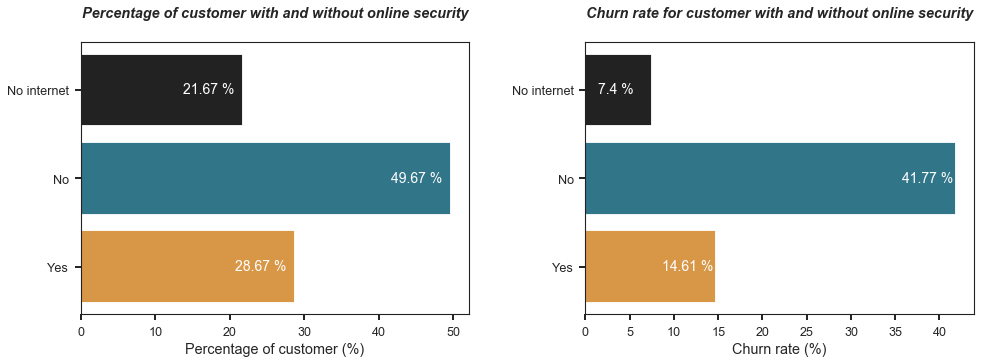

In [12]:
# Churn rate of customer with online security 
tot_os_churn = len(telco_df[(telco_df.OnlineSecurity == 'Yes') & (telco_df.Churn == 'Yes')].index)
tot_os = len(telco_df[(telco_df.OnlineSecurity == 'Yes')].index)
pct_os_churn = tot_os_churn/tot_os*100

# Churn rate of customer without online security
tot_nos_churn = len(telco_df[(telco_df.OnlineSecurity == 'No') & (telco_df.Churn == 'Yes')].index)
tot_nos = len(telco_df[(telco_df.OnlineSecurity == 'No')].index)
pct_nos_churn = tot_nos_churn/tot_nos*100

# Churn rate of customer without no internet
tot_nosi_churn = len(telco_df[(telco_df.OnlineSecurity == 'No internet service') & (telco_df.Churn == 'Yes')].index)
tot_nosi = len(telco_df[(telco_df.OnlineSecurity == 'No internet service')].index)
pct_nosi_churn = tot_nosi_churn/tot_nosi*100

# Percentage of customer who are with and without online security
pct_tot_os = tot_os/len(telco_df.index)*100
pct_tot_nos = tot_nos/len(telco_df.index)*100
pct_tot_nosi = tot_nosi/len(telco_df.index)*100

# Plot percentage of customer who are with and without online security
% matplotlib inline
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
x = [pct_tot_os, pct_tot_nos, pct_tot_nosi]
y = ['Yes', 'No', 'No internet']
y_pos = np.arange(len(y))
ax[0].barh(y_pos, x)
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(y)
ax[0].grid(None)
ax[0].get_children()[0].set_color('#d89747')
ax[0].get_children()[1].set_color('#317589')
ax[0].get_children()[2].set_color('k')
ax[0].tick_params(length = 6, width = 2)
ax[0].set_title('Percentage of customer with and without online security', 
                pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[0].set_xlabel('Percentage of customer (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[0].text(v - 8, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[0].spines:
    ax[0].spines[spine].set_color('k') # Plot black border

# Plot churn of customer who are with and without online security
x = [pct_os_churn, pct_nos_churn, pct_nosi_churn]
y = ['Yes', 'No', 'No internet']
y_pos = np.arange(len(y))
ax[1].barh(y_pos, x)
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(y)
ax[1].grid(None)
ax[1].get_children()[0].set_color('#d89747')
ax[1].get_children()[1].set_color('#317589')
ax[1].get_children()[2].set_color('k')
ax[1].tick_params(length = 6, width = 2)
ax[1].set_title('Churn rate for customer with and without online security', 
                pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[1].set_xlabel('Churn rate (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[1].text(v - 6, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[1].spines:
    ax[1].spines[spine].set_color('k') # Plot black border

# adjust white space between subplots
plt.subplots_adjust(wspace = 0.3)

# show plots
plt.show()

* Approximately half of all the customers have no online security at 49.67 %.
* Out of those 49.67 %, 41.77 % of these customers churned compared to churn rate of 7.4 % and 14.61 % for customers with no internet and customers with online security respectively.

[Back to Table of Content](#TOC)

***
**2.11** *OnlineBackup* <a id = '2.11'></a>
***
The 'OnlineBackup' column shows whether the customer has online backup or not.

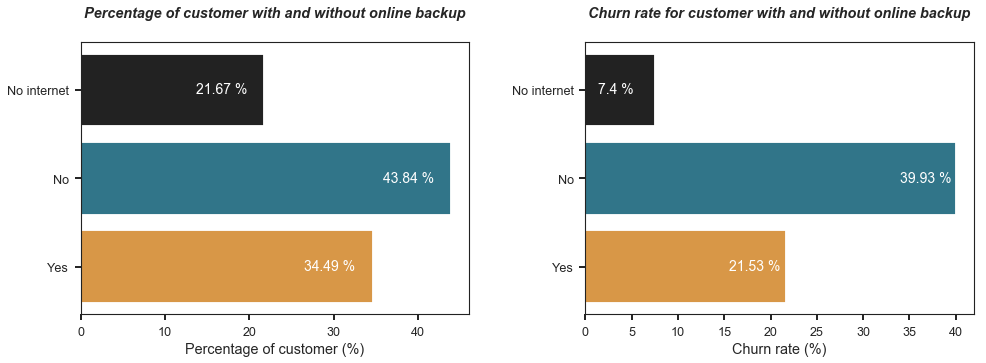

In [13]:
# Churn rate of customer with online backup 
tot_ob_churn = len(telco_df[(telco_df.OnlineBackup == 'Yes') & (telco_df.Churn == 'Yes')].index)
tot_ob = len(telco_df[(telco_df.OnlineBackup == 'Yes')].index)
pct_ob_churn = tot_ob_churn/tot_ob*100

# Churn rate of customer without online backup
tot_nob_churn = len(telco_df[(telco_df.OnlineBackup == 'No') & (telco_df.Churn == 'Yes')].index)
tot_nob = len(telco_df[(telco_df.OnlineBackup == 'No')].index)
pct_nob_churn = tot_nob_churn/tot_nob*100

# Churn rate of customer without no internet
tot_nobi_churn = len(telco_df[(telco_df.OnlineBackup == 'No internet service') & (telco_df.Churn == 'Yes')].index)
tot_nobi = len(telco_df[(telco_df.OnlineBackup == 'No internet service')].index)
pct_nobi_churn = tot_nobi_churn/tot_nobi*100

# Percentage of customer who are with and without online backup
pct_tot_ob = tot_ob/len(telco_df.index)*100
pct_tot_nob = tot_nob/len(telco_df.index)*100
pct_tot_nobi = tot_nobi/len(telco_df.index)*100

# Plot percentage of customer who are with and without online backup
% matplotlib inline
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
x = [pct_tot_ob, pct_tot_nob, pct_tot_nobi]
y = ['Yes', 'No', 'No internet']
y_pos = np.arange(len(y))
ax[0].barh(y_pos, x)
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(y)
ax[0].grid(None)
ax[0].get_children()[0].set_color('#d89747')
ax[0].get_children()[1].set_color('#317589')
ax[0].get_children()[2].set_color('k')
ax[0].tick_params(length = 6, width = 2)
ax[0].set_title('Percentage of customer with and without online backup', 
                pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[0].set_xlabel('Percentage of customer (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[0].text(v - 8, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[0].spines:
    ax[0].spines[spine].set_color('k') # Plot black border

# Plot churn of customer who are with and without online security
x = [pct_ob_churn, pct_nob_churn, pct_nobi_churn]
y = ['Yes', 'No', 'No internet']
y_pos = np.arange(len(y))
ax[1].barh(y_pos, x)
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(y)
ax[1].grid(None)
ax[1].get_children()[0].set_color('#d89747')
ax[1].get_children()[1].set_color('#317589')
ax[1].get_children()[2].set_color('k')
ax[1].tick_params(length = 6, width = 2)
ax[1].set_title('Churn rate for customer with and without online backup', 
                pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[1].set_xlabel('Churn rate (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[1].text(v - 6, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[1].spines:
    ax[1].spines[spine].set_color('k') # Plot black border

# adjust white space between subplots
plt.subplots_adjust(wspace = 0.3)

# show plots
plt.show()

* 43.84 % of all the customers didn't subscribe to the online backup service.
* The same 43.84 % of customers have the highest churn rate at 39.93 % compared to 7.4 % and 21.53 % for customers without internet and customers with online backup respectively.

[Back to Table of Content](#TOC)

***
**2.12** *DeviceProtection* <a id = '2.12'></a>
***
The 'DeviceProtection' column shows whether the customer has device protection or not.

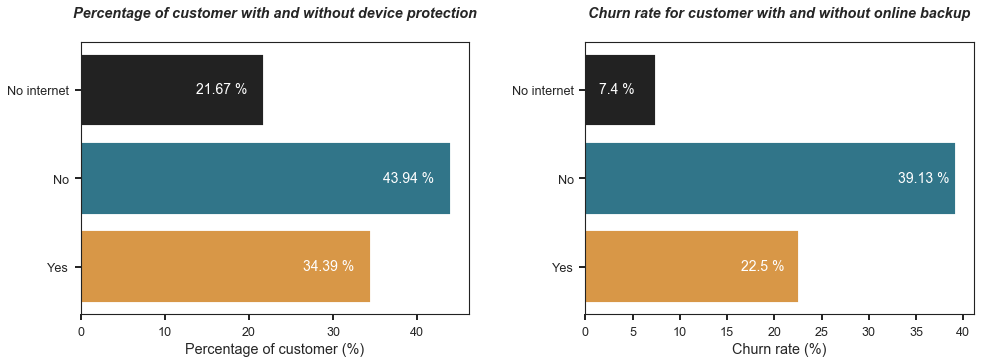

In [14]:
# Churn rate of customer with device protection 
tot_dp_churn = len(telco_df[(telco_df.DeviceProtection == 'Yes') & (telco_df.Churn == 'Yes')].index)
tot_dp = len(telco_df[(telco_df.DeviceProtection == 'Yes')].index)
pct_dp_churn = tot_dp_churn/tot_dp*100

# Churn rate of customer without device protection
tot_ndp_churn = len(telco_df[(telco_df.DeviceProtection == 'No') & (telco_df.Churn == 'Yes')].index)
tot_ndp = len(telco_df[(telco_df.DeviceProtection == 'No')].index)
pct_ndp_churn = tot_ndp_churn/tot_ndp*100

# Churn rate of customer without no internet
tot_nodi_churn = len(telco_df[(telco_df.DeviceProtection == 'No internet service') & (telco_df.Churn == 'Yes')].index)
tot_nodi = len(telco_df[(telco_df.DeviceProtection == 'No internet service')].index)
pct_nodi_churn = tot_nobi_churn/tot_nodi*100

# Percentage of customer who are with and without device protection
pct_tot_dp = tot_dp/len(telco_df.index)*100
pct_tot_ndp = tot_ndp/len(telco_df.index)*100
pct_tot_nodi = tot_nodi/len(telco_df.index)*100

# Plot percentage of customer who are with and without device protection
% matplotlib inline
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
x = [pct_tot_dp, pct_tot_ndp, pct_tot_nodi]
y = ['Yes', 'No', 'No internet']
y_pos = np.arange(len(y))
ax[0].barh(y_pos, x)
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(y)
ax[0].grid(None)
ax[0].get_children()[0].set_color('#d89747')
ax[0].get_children()[1].set_color('#317589')
ax[0].get_children()[2].set_color('k')
ax[0].tick_params(length = 6, width = 2)
ax[0].set_title('Percentage of customer with and without device protection', 
                pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[0].set_xlabel('Percentage of customer (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[0].text(v - 8, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[0].spines:
    ax[0].spines[spine].set_color('k') # Plot black border

# Plot churn of customer who are with and without device protection
x = [pct_dp_churn, pct_ndp_churn, pct_nodi_churn]
y = ['Yes', 'No', 'No internet']
y_pos = np.arange(len(y))
ax[1].barh(y_pos, x)
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(y)
ax[1].grid(None)
ax[1].get_children()[0].set_color('#d89747')
ax[1].get_children()[1].set_color('#317589')
ax[1].get_children()[2].set_color('k')
ax[1].tick_params(length = 6, width = 2)
ax[1].set_title('Churn rate for customer with and without online backup', 
                pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[1].set_xlabel('Churn rate (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[1].text(v - 6, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[1].spines:
    ax[1].spines[spine].set_color('k') # Plot black border

# adjust white space between subplots
plt.subplots_adjust(wspace = 0.3)

# show plots
plt.show()

* 43.94 % of all the customers have no device protection.
* Customers who have no device precotection despite having internet service have the highest churn rate at 39.13 %.

[Back to Table of Content](#TOC)

***
**2.13** *TechSupport* <a id = '2.13'></a>
***
The 'TechSupport' column shows whether the customer has tech support or not.

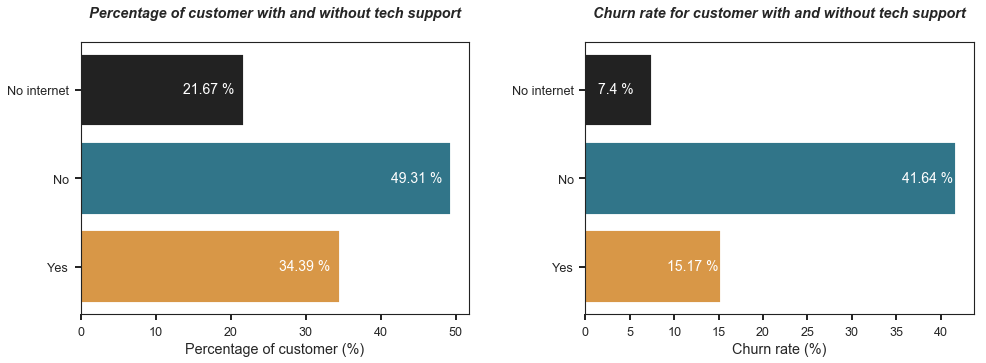

In [15]:
# Churn rate of customer with tech support 
tot_ts_churn = len(telco_df[(telco_df.TechSupport == 'Yes') & (telco_df.Churn == 'Yes')].index)
tot_ts = len(telco_df[(telco_df.TechSupport == 'Yes')].index)
pct_ts_churn = tot_ts_churn/tot_ts*100

# Churn rate of customer without tech support
tot_nts_churn = len(telco_df[(telco_df.TechSupport == 'No') & (telco_df.Churn == 'Yes')].index)
tot_nts = len(telco_df[(telco_df.TechSupport == 'No')].index)
pct_nts_churn = tot_nts_churn/tot_nts*100

# Churn rate of customer without no internet
tot_noti_churn = len(telco_df[(telco_df.TechSupport == 'No internet service') & (telco_df.Churn == 'Yes')].index)
tot_noti = len(telco_df[(telco_df.TechSupport == 'No internet service')].index)
pct_noti_churn = tot_noti_churn/tot_noti*100

# Percentage of customer who are with and without tech support
pct_tot_ts = tot_dp/len(telco_df.index)*100
pct_tot_nts = tot_nts/len(telco_df.index)*100
pct_tot_noti = tot_noti/len(telco_df.index)*100

# Plot percentage of customer who are with and without tech support
% matplotlib inline
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
x = [pct_tot_ts, pct_tot_nts, pct_tot_noti]
y = ['Yes', 'No', 'No internet']
y_pos = np.arange(len(y))
ax[0].barh(y_pos, x)
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(y)
ax[0].grid(None)
ax[0].get_children()[0].set_color('#d89747')
ax[0].get_children()[1].set_color('#317589')
ax[0].get_children()[2].set_color('k')
ax[0].tick_params(length = 6, width = 2)
ax[0].set_title('Percentage of customer with and without tech support', 
                pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[0].set_xlabel('Percentage of customer (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[0].text(v - 8, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[0].spines:
    ax[0].spines[spine].set_color('k') # Plot black border

# Plot churn of customer who are with and without tech support
x = [pct_ts_churn, pct_nts_churn, pct_noti_churn]
y = ['Yes', 'No', 'No internet']
y_pos = np.arange(len(y))
ax[1].barh(y_pos, x)
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(y)
ax[1].grid(None)
ax[1].get_children()[0].set_color('#d89747')
ax[1].get_children()[1].set_color('#317589')
ax[1].get_children()[2].set_color('k')
ax[1].tick_params(length = 6, width = 2)
ax[1].set_title('Churn rate for customer with and without tech support', 
                pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[1].set_xlabel('Churn rate (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[1].text(v - 6, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[1].spines:
    ax[1].spines[spine].set_color('k') # Plot black border

# adjust white space between subplots
plt.subplots_adjust(wspace = 0.3)

# show plots
plt.show()

* A majority of the customer didn't subscribed to the tech support service at 49.31 %.
* The churn rate for this group of customer is the highest at 41.64 %.

[Back to Table of Content](#TOC)

***
**2.14** *StreamingTV* <a id = '2.14'></a>
***
The 'StreamingTV' column shows whether the customer has streaming TV or not.

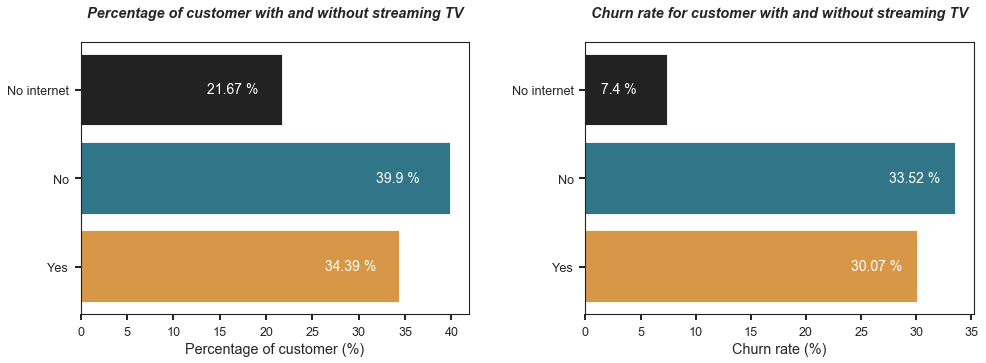

In [16]:
# Churn rate of customer with streaming tv 
tot_st_churn = len(telco_df[(telco_df.StreamingTV == 'Yes') & (telco_df.Churn == 'Yes')].index)
tot_st = len(telco_df[(telco_df.StreamingTV == 'Yes')].index)
pct_st_churn = tot_st_churn/tot_st*100

# Churn rate of customer without streaming tv
tot_nst_churn = len(telco_df[(telco_df.StreamingTV == 'No') & (telco_df.Churn == 'Yes')].index)
tot_nst = len(telco_df[(telco_df.StreamingTV == 'No')].index)
pct_nst_churn = tot_nst_churn/tot_nst*100

# Churn rate of customer without no internet
tot_nosti_churn = len(telco_df[(telco_df.StreamingTV == 'No internet service') & (telco_df.Churn == 'Yes')].index)
tot_nosti = len(telco_df[(telco_df.StreamingTV == 'No internet service')].index)
pct_nosti_churn = tot_nosti_churn/tot_nosti*100

# Percentage of customer who are with and without streaming tv
pct_tot_st = tot_dp/len(telco_df.index)*100
pct_tot_nst = tot_nst/len(telco_df.index)*100
pct_tot_nosti = tot_nosti/len(telco_df.index)*100

# Plot percentage of customer who are with and without streaming tv
% matplotlib inline
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
x = [pct_tot_st, pct_tot_nst, pct_tot_nosti]
y = ['Yes', 'No', 'No internet']
y_pos = np.arange(len(y))
ax[0].barh(y_pos, x)
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(y)
ax[0].grid(None)
ax[0].get_children()[0].set_color('#d89747')
ax[0].get_children()[1].set_color('#317589')
ax[0].get_children()[2].set_color('k')
ax[0].tick_params(length = 6, width = 2)
ax[0].set_title('Percentage of customer with and without streaming TV', 
                pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[0].set_xlabel('Percentage of customer (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[0].text(v - 8, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[0].spines:
    ax[0].spines[spine].set_color('k') # Plot black border

# Plot churn of customer who are with and without streaming tv
x = [pct_st_churn, pct_nst_churn, pct_nosti_churn]
y = ['Yes', 'No', 'No internet']
y_pos = np.arange(len(y))
ax[1].barh(y_pos, x)
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(y)
ax[1].grid(None)
ax[1].get_children()[0].set_color('#d89747')
ax[1].get_children()[1].set_color('#317589')
ax[1].get_children()[2].set_color('k')
ax[1].tick_params(length = 6, width = 2)
ax[1].set_title('Churn rate for customer with and without streaming TV', 
                pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[1].set_xlabel('Churn rate (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[1].text(v - 6, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[1].spines:
    ax[1].spines[spine].set_color('k') # Plot black border

# adjust white space between subplots
plt.subplots_adjust(wspace = 0.3)

# show plots
plt.show()

* Most of the customers do not subscribe to the streaming TV service.
* However, those that do subscribe to the streaming TV service have a higher churn rate compared to the other groups at 33.52 %.

[Back to Table of Content](#TOC)

***
**2.15** *StreamingMovies* <a id = '2.15'></a>
***
The 'StreamingMovies' column shows whether the customer has streaming movies or not.

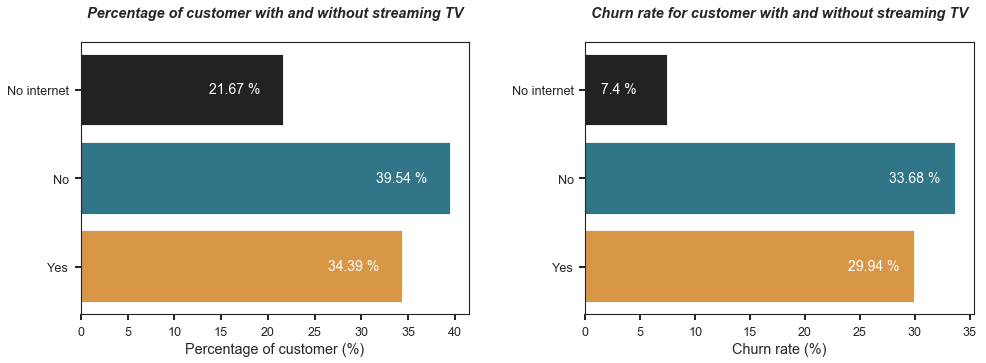

In [17]:
# Churn rate of customer with streaming movie 
tot_sm_churn = len(telco_df[(telco_df.StreamingMovies == 'Yes') & (telco_df.Churn == 'Yes')].index)
tot_sm = len(telco_df[(telco_df.StreamingMovies == 'Yes')].index)
pct_sm_churn = tot_sm_churn/tot_sm*100

# Churn rate of customer without streaming movie
tot_nsm_churn = len(telco_df[(telco_df.StreamingMovies == 'No') & (telco_df.Churn == 'Yes')].index)
tot_nsm = len(telco_df[(telco_df.StreamingMovies == 'No')].index)
pct_nsm_churn = tot_nsm_churn/tot_nsm*100

# Churn rate of customer without no internet
tot_nosmi_churn = len(telco_df[(telco_df.StreamingMovies == 'No internet service') & (telco_df.Churn == 'Yes')].index)
tot_nosmi = len(telco_df[(telco_df.StreamingMovies == 'No internet service')].index)
pct_nosmi_churn = tot_nosmi_churn/tot_nosmi*100

# Percentage of customer who are with and without streaming movie
pct_tot_sm = tot_dp/len(telco_df.index)*100
pct_tot_nsm = tot_nsm/len(telco_df.index)*100
pct_tot_nosmi = tot_nosmi/len(telco_df.index)*100

# Plot percentage of customer who are with and without streaming movie
% matplotlib inline
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
x = [pct_tot_sm, pct_tot_nsm, pct_tot_nosmi]
y = ['Yes', 'No', 'No internet']
y_pos = np.arange(len(y))
ax[0].barh(y_pos, x)
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(y)
ax[0].grid(None)
ax[0].get_children()[0].set_color('#d89747')
ax[0].get_children()[1].set_color('#317589')
ax[0].get_children()[2].set_color('k')
ax[0].tick_params(length = 6, width = 2)
ax[0].set_title('Percentage of customer with and without streaming TV', 
                pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[0].set_xlabel('Percentage of customer (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[0].text(v - 8, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[0].spines:
    ax[0].spines[spine].set_color('k') # Plot black border

# Plot churn of customer who are with and without streaming movie
x = [pct_sm_churn, pct_nsm_churn, pct_nosmi_churn]
y = ['Yes', 'No', 'No internet']
y_pos = np.arange(len(y))
ax[1].barh(y_pos, x)
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(y)
ax[1].grid(None)
ax[1].get_children()[0].set_color('#d89747')
ax[1].get_children()[1].set_color('#317589')
ax[1].get_children()[2].set_color('k')
ax[1].tick_params(length = 6, width = 2)
ax[1].set_title('Churn rate for customer with and without streaming TV', 
                pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[1].set_xlabel('Churn rate (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[1].text(v - 6, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[1].spines:
    ax[1].spines[spine].set_color('k') # Plot black border

# adjust white space between subplots
plt.subplots_adjust(wspace = 0.3)

# show plots
plt.show()

* Most of the customers do not subscribe to the streaming movie service.
* However, those that do subscribe to the streaming movie service have a higher churn rate compared to the other groups at 33.68 %.

[Back to Table of Content](#TOC)

***
**2.16** *Contract* <a id = '2.16'></a>
***
The 'Contract' column shows The contract term of the customer.

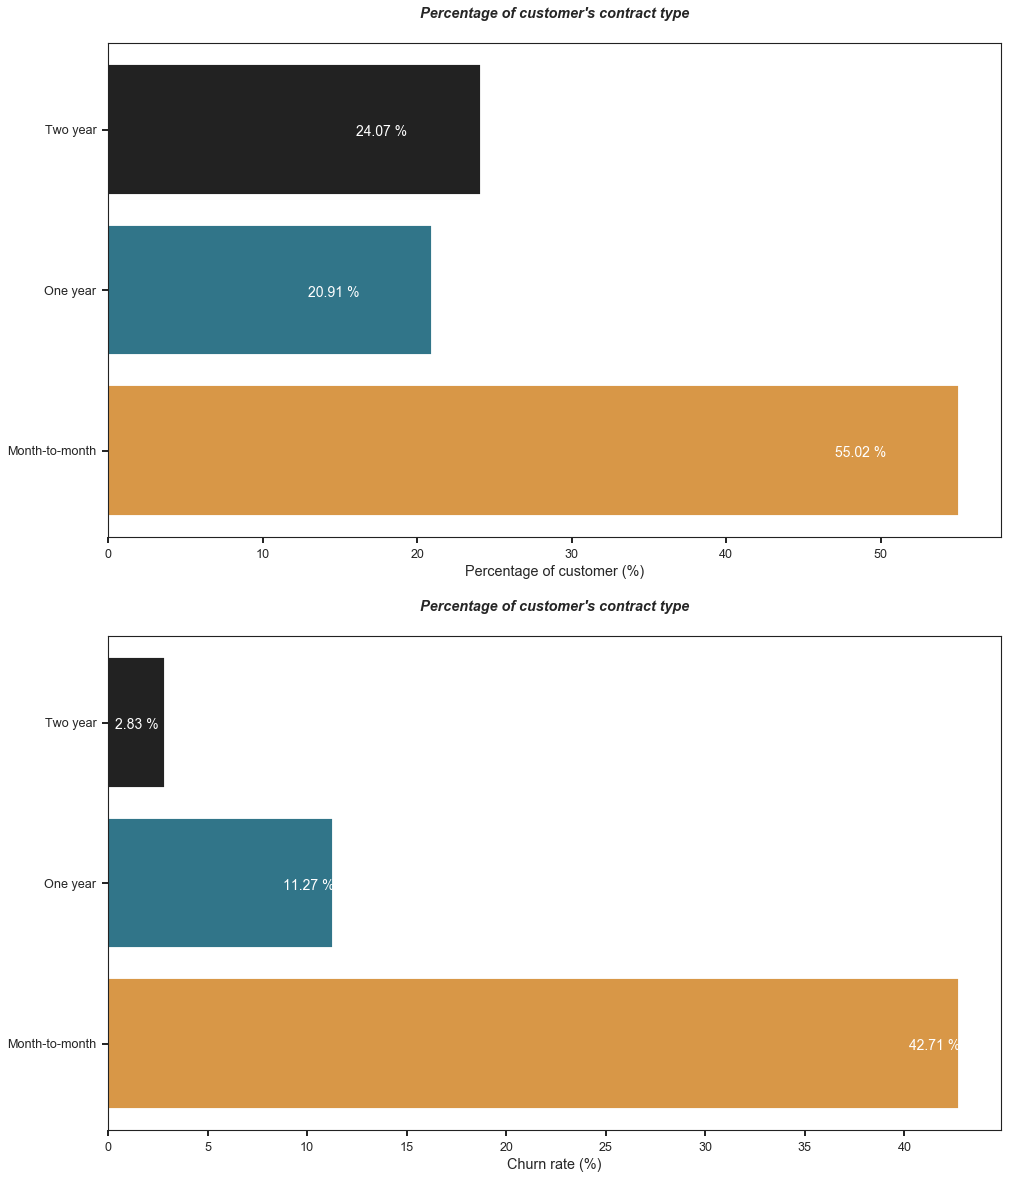

In [18]:
# Churn rate of customer with month-to-month contract 
tot_mtm_churn = len(telco_df[(telco_df.Contract == 'Month-to-month') & (telco_df.Churn == 'Yes')].index)
tot_mtm = len(telco_df[(telco_df.Contract == 'Month-to-month')].index)
pct_mtm_churn = tot_mtm_churn/tot_mtm*100

# Churn rate of customer with one year contract
tot_oy_churn = len(telco_df[(telco_df.Contract == 'One year') & (telco_df.Churn == 'Yes')].index)
tot_oy = len(telco_df[(telco_df.Contract == 'One year')].index)
pct_oy_churn = tot_oy_churn/tot_oy*100

# Churn rate of customer with two-year contract
tot_ty_churn = len(telco_df[(telco_df.Contract == 'Two year') & (telco_df.Churn == 'Yes')].index)
tot_ty = len(telco_df[(telco_df.Contract == 'Two year')].index)
pct_ty_churn = tot_ty_churn/tot_ty*100

# Percentage of customer who are with contract
pct_tot_mtm = tot_mtm/len(telco_df.index)*100
pct_tot_oy = tot_oy/len(telco_df.index)*100
pct_tot_ty = tot_ty/len(telco_df.index)*100

# Plot percentage of customer who are with contract
% matplotlib inline
fig, ax = plt.subplots(2, 1, figsize = (16, 20))
x = [pct_tot_mtm, pct_tot_oy, pct_tot_ty]
y = ['Month-to-month', 'One year', 'Two year']
y_pos = np.arange(len(y))
ax[0].barh(y_pos, x)
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(y)
ax[0].grid(None)
ax[0].get_children()[0].set_color('#d89747')
ax[0].get_children()[1].set_color('#317589')
ax[0].get_children()[2].set_color('k')
ax[0].tick_params(length = 6, width = 2)
ax[0].set_title('Percentage of customer\'s contract type', 
                pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[0].set_xlabel('Percentage of customer (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[0].text(v - 8, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[0].spines:
    ax[0].spines[spine].set_color('k') # Plot black border

# Plot churn of customer who are with contract
x = [pct_mtm_churn, pct_oy_churn, pct_ty_churn]
y = ['Month-to-month', 'One year', 'Two year']
y_pos = np.arange(len(y))
ax[1].barh(y_pos, x)
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(y)
ax[1].grid(None)
ax[1].get_children()[0].set_color('#d89747')
ax[1].get_children()[1].set_color('#317589')
ax[1].get_children()[2].set_color('k')
ax[1].tick_params(length = 6, width = 2)
ax[1].set_title('Percentage of customer\'s contract type', 
                pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[1].set_xlabel('Churn rate (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[1].text(v - 2.5, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[1].spines:
    ax[1].spines[spine].set_color('k') # Plot black border

# adjust white space between subplots
plt.subplots_adjust(wspace = 0.3)

# show plots
plt.show()

* More than half of the customers were under month-to-month contracts, with 42.71 % of this specific group churning.
* Meanwhile, 24.07 % of all the customers were under two year contracts. Only 2.83 % of this specific group churned.

[Back to Table of Content](#TOC)

***
**2.17** *PaperlessBilling* <a id = '2.17'></a>
***
The 'PaperlessBilling' column shows whether the customer has paperless billing or not.

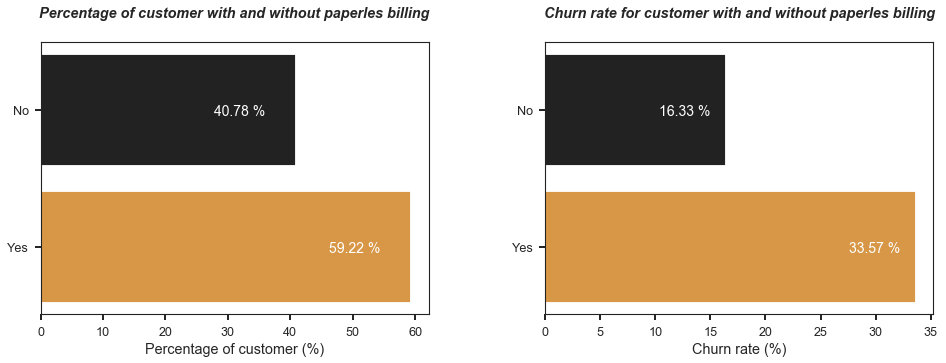

In [19]:
# Churn rate of customer with paperles billing 
tot_pb_churn = len(telco_df[(telco_df.PaperlessBilling == 'Yes') & (telco_df.Churn == 'Yes')].index)
tot_pb = len(telco_df[(telco_df.PaperlessBilling == 'Yes')].index)
pct_pb_churn = tot_pb_churn/tot_pb*100

# Churn rate of customer without paperles billing
tot_npb_churn = len(telco_df[(telco_df.PaperlessBilling == 'No') & (telco_df.Churn == 'Yes')].index)
tot_npb = len(telco_df[(telco_df.PaperlessBilling == 'No')].index)
pct_npb_churn = tot_npb_churn/tot_npb*100

# Percentage of customer who are with and without paperles billing
pct_tot_pb = tot_pb/len(telco_df.index)*100
pct_tot_npb = tot_npb/len(telco_df.index)*100

# Plot percentage of customer who are with and without paperles billing
% matplotlib inline
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
x = [pct_tot_pb, pct_tot_npb]
y = ['Yes', 'No']
y_pos = np.arange(len(y))
ax[0].barh(y_pos, x)
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(y)
ax[0].grid(None)
ax[0].get_children()[0].set_color('#d89747')
ax[0].get_children()[1].set_color('k')
ax[0].tick_params(length = 6, width = 2)
ax[0].set_title('Percentage of customer with and without paperles billing', pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[0].set_xlabel('Percentage of customer (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[0].text(v - 13, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[0].spines:
    ax[0].spines[spine].set_color('k') # Plot black border

# Plot churn of customer who are with and without paperles billing
x = [pct_pb_churn, pct_npb_churn]
y = ['Yes', 'No']
y_pos = np.arange(len(y))
ax[1].barh(y_pos, x)
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(y)
ax[1].grid(None)
ax[1].get_children()[0].set_color('#d89747')
ax[1].get_children()[1].set_color('k')
ax[1].tick_params(length = 6, width = 2)
ax[1].set_title('Churn rate for customer with and without paperles billing', pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[1].set_xlabel('Churn rate (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[1].text(v - 6, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[1].spines:
    ax[1].spines[spine].set_color('k') # Plot black border

# adjust white space between subplots
plt.subplots_adjust(wspace = 0.3)

# show plots
plt.show()

* More than half of the customer are using paperless billing.
* The churn rate for customers using paperless billing are higher than those not using paperless billing, at 33.57 % and 16.33 % respectively.

[Back to Table of Content](#TOC)

***
**2.18** *PaymentMethod* <a id = '2.18'></a>
***
The 'PaymentMethod' column shows the customer’s payment method.

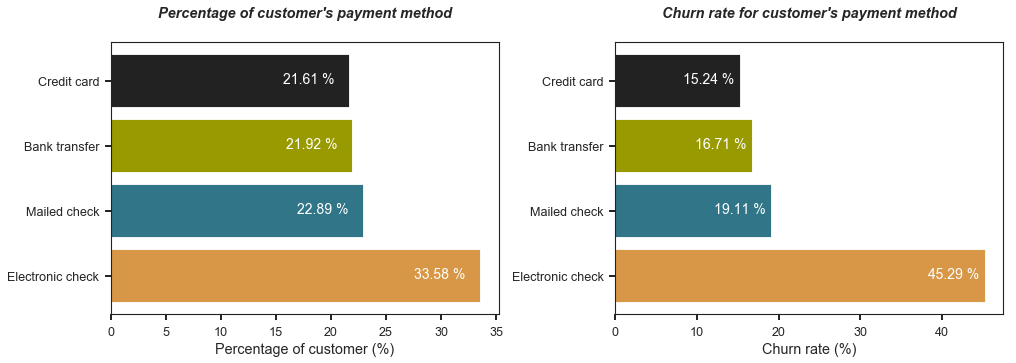

In [20]:
# Churn rate of customer with electronic check
tot_ec_churn = len(telco_df[(telco_df.PaymentMethod == 'Electronic check') & (telco_df.Churn == 'Yes')].index)
tot_ec = len(telco_df[(telco_df.PaymentMethod == 'Electronic check')].index)
pct_ec_churn = tot_ec_churn/tot_ec*100

# Churn rate of customer with mailed check
tot_mc_churn = len(telco_df[(telco_df.PaymentMethod == 'Mailed check') & (telco_df.Churn == 'Yes')].index)
tot_mc = len(telco_df[(telco_df.PaymentMethod == 'Mailed check')].index)
pct_mc_churn = tot_mc_churn/tot_mc*100

# Churn rate of customer with bank transfer (automatic)
tot_bt_churn = len(telco_df[(telco_df.PaymentMethod == 'Bank transfer (automatic)') & (telco_df.Churn == 'Yes')].index)
tot_bt = len(telco_df[(telco_df.PaymentMethod == 'Bank transfer (automatic)')].index)
pct_bt_churn = tot_bt_churn/tot_bt*100

# Churn rate of customer with credit card (automatic)
tot_cc_churn = len(telco_df[(telco_df.PaymentMethod == 'Credit card (automatic)') & (telco_df.Churn == 'Yes')].index)
tot_cc = len(telco_df[(telco_df.PaymentMethod == 'Credit card (automatic)')].index)
pct_cc_churn = tot_cc_churn/tot_cc*100

# Percentage of customer's payment method
pct_tot_ec = tot_ec/len(telco_df.index)*100
pct_tot_mc = tot_mc/len(telco_df.index)*100
pct_tot_bt = tot_bt/len(telco_df.index)*100
pct_tot_cc = tot_cc/len(telco_df.index)*100

# Plot percentage of customer's payment method
% matplotlib inline
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
x = [pct_tot_ec, pct_tot_mc, pct_tot_bt, pct_tot_cc]
y = ['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card']
y_pos = np.arange(len(y))
ax[0].barh(y_pos, x)
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(y)
ax[0].grid(None)
ax[0].get_children()[0].set_color('#d89747')
ax[0].get_children()[1].set_color('#317589')
ax[0].get_children()[2].set_color('#999900')
ax[0].get_children()[3].set_color('k')
ax[0].tick_params(length = 6, width = 2)
ax[0].set_title('Percentage of customer\'s payment method', 
                pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[0].set_xlabel('Percentage of customer (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[0].text(v - 6, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[0].spines:
    ax[0].spines[spine].set_color('k') # Plot black border

# Plot churn of customer's payment method
x = [pct_ec_churn, pct_mc_churn, pct_bt_churn, pct_cc_churn]
y = ['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card']
y_pos = np.arange(len(y))
ax[1].barh(y_pos, x)
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(y)
ax[1].grid(None)
ax[1].get_children()[0].set_color('#d89747')
ax[1].get_children()[1].set_color('#317589')
ax[1].get_children()[2].set_color('#999900')
ax[1].get_children()[3].set_color('k')
ax[1].tick_params(length = 6, width = 2)
ax[1].set_title('Churn rate for customer\'s payment method', 
                pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax[1].set_xlabel('Churn rate (%)');
for i, v in enumerate(np.round(x, 2)):
    ax[1].text(v - 7, i - 0.04, str(float(v))+' %', color='white', fontsize = 14) # Annotate
for spine in ax[1].spines:
    ax[1].spines[spine].set_color('k') # Plot black border

# adjust white space between subplots
plt.subplots_adjust(wspace = 0.3)

# show plots
plt.show()

* A majority of the customers used electronic check as payment method.
* In addition, customers who used electronic check have the highest churn rate, with almost half (45.29 %) of customers in this group churning.

[Back to Table of Content](#TOC)

***
**2.19** *MonthlyCharges* <a id = '2.19'></a>
***
The 'MonthlyCharges' column shows the amount charged to the customer monthly.

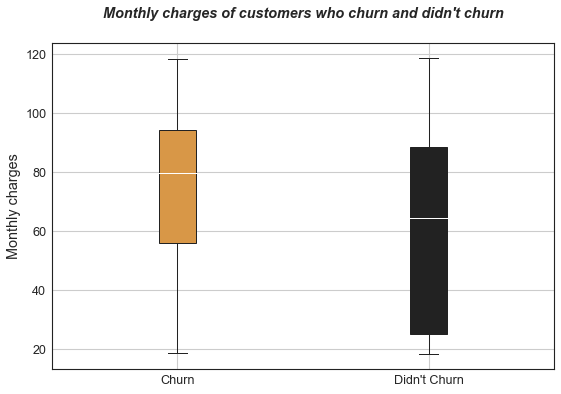

In [21]:
# get monthly charges of customer who churned
mc_churn = telco_df[telco_df.Churn == 'Yes'].MonthlyCharges.values

# get monthly charges of customer who didn't churned
mc_not_churn = telco_df[telco_df.Churn == 'No'].MonthlyCharges.values

# Plot a boxplot of monthly charges for customer who churn and didn't churn
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
mc_bp = ax.boxplot([mc_churn, mc_not_churn], patch_artist = True)

# x ticks labels
ax.set_xticklabels(['Churn', 'Didn\'t Churn'])

# Change color for churn
mc_bp['boxes'][0].set(facecolor = '#d89747')
mc_bp['medians'][0].set(color = 'w')

# Change color for not churn
mc_bp['boxes'][1].set(facecolor = 'k' )
mc_bp['medians'][1].set(color = 'w')

# Plot black border
for spine in ax.spines:
    ax.spines[spine].set_color('k') 
    
# Label y-axis
ax.set_ylabel('Monthly charges')

# Set title
ax.set_title('Monthly charges of customers who churn and didn\'t churn', pad = 25, 
             fontweight = 'bold', fontstyle = 'italic')

plt.show()

* The range of monthly charges are about the same for both customers who churned and didn't churned.
* Based on the medians of both box plot, customers who churned tend to have higher monthly charges compared to customer who didn't churn.

[Back to Table of Content](#TOC)

***
**2.20** *TotalCharges* <a id = '2.20'></a>
***
The 'TotalCharges' column shows the The total amount charged to the customer.

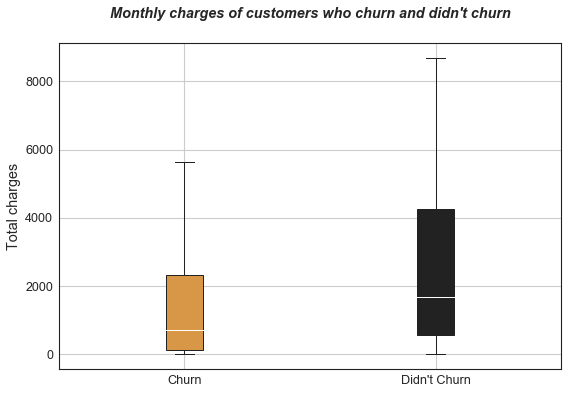

In [22]:
# Impute missing value
telco_df['TotalCharges'] = telco_df['TotalCharges'].replace(" ", 0).astype('float32')

# get Total charges of customer who churned
tc_churn = telco_df[telco_df.Churn == 'Yes'].TotalCharges.values


# get total charges of customer who didn't churned
tc_not_churn = telco_df[telco_df.Churn == 'No'].TotalCharges.values

# Plot a boxplot of total charges for customer who churn and didn't churn
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
tc_bp = ax.boxplot([tc_churn, tc_not_churn], patch_artist = True)

# x ticks labels
ax.set_xticklabels(['Churn', 'Didn\'t Churn'])

# Change color for churn
tc_bp['boxes'][0].set(facecolor = '#d89747')
tc_bp['medians'][0].set(color = 'w')

# Change color for not churn
tc_bp['boxes'][1].set(facecolor = 'k' )
tc_bp['medians'][1].set(color = 'w')

# Plot black border
for spine in ax.spines:
    ax.spines[spine].set_color('k') 
    
# Label y-axis
ax.set_ylabel('Total charges')

# Set title
ax.set_title('Monthly charges of customers who churn and didn\'t churn', pad = 25, 
             fontweight = 'bold', fontstyle = 'italic')

plt.show()

* The figure above seems to indicate that customers with lower total charges are more likely to churn.
* It supports the notion that customer with shorter tenure are more likely to churn.

[Back to Table of Content](#TOC)

# 3. One Hot Encoding <a id = '3'></a>

* One hot encoding is used for categorical features and target.

In [23]:
# replace 'No internet service' to 'No'
no_internet_replace_no = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                         'StreamingTV', 'StreamingMovies']
for col in no_internet_replace_no:
    telco_df[col] = telco_df[col].replace({'No internet service' : 'No'})

# replace 'No phone service' to 'no'
telco_df['MultipleLines'] = telco_df['MultipleLines'].replace({'No phone service' : 'No'})
    
# column name of data which are categorical
cat_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
           'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
           'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

# Create dummy data for each column, drop original and add dummy data
telco_dummy_df = telco_df

for col in cat_cols:
    if telco_df[col].nunique() == 2:
        telco_dummy_df[col], _ = pd.factorize(telco_df[col])
        
    else:
        telco_dummy_df = pd.get_dummies(telco_dummy_df, columns = [col])
    

# print head
print('\n\nNew Dataframe')
display(telco_dummy_df.head())



New Dataframe


customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0  7590-VHVEG       0              0        0           0       1   
1  5575-GNVDE       1              0        1           0      34   
2  3668-QPYBK       1              0        1           0       2   
3  7795-CFOCW       1              0        1           0      45   
4  9237-HQITU       0              0        1           0       2   

   PhoneService  MultipleLines  OnlineSecurity  OnlineBackup  \
0             0              0               0             0   
1             1              0               1             1   
2             1              0               1             0   
3             0              0               1             1   
4             1              0               0             1   

              ...              InternetService_DSL  \
0             ...                                1   
1             ...                                1   
2             ...                                1   
3             ...                                1   
4             ...                                0   

   InternetService_Fiber optic  InternetService_No  Contract_Month-to-month  \
0                            0                   0                        1   
1                            0                   0                        0   
2                            0                   0                        1   
3                            0                   0                        0   
4                            1                   0                        1   

   Contract_One year  Contract_Two year  \
0                  0                  0   
1                  1                  0   
2                  0                  0   
3                  1                  0   
4                  0                  0   

   PaymentMethod_Bank transfer (automatic)  \
0                                        0   
1                                        0   
2                                        0   
3                                        1   
4                                        0   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check  
0                           0  
1                           1  
2                           1  
3                           0  
4                           0  

[5 rows x 28 columns]

[Back to Table of Content](#TOC)

# 4. Univariate Selection <a id = '4'></a>

* For feature selection, Univariate Statistical Test (chi-squared) was used

In [24]:
# Seperate features and class
x = telco_dummy_df.drop(['customerID', 'Churn'], axis=1)
y = telco_dummy_df[['Churn']]

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

select_five = SelectKBest(score_func = chi2)
select_five_fit = select_five.fit(x, y)

score_selectk = pd.DataFrame({"Features":x.columns,
                             "Scores": select_five_fit.scores_,
                             "P-values": 
                              select_five_fit.pvalues_}).sort_values(by = "Scores", 
                                                                    ascending = False)
print(score_selectk)

                                   Features       P-values         Scores
15                             TotalCharges   0.000000e+00  624292.006842
4                                    tenure   0.000000e+00   16278.923685
14                           MonthlyCharges   0.000000e+00    3680.787699
19                  Contract_Month-to-month  4.459832e-115     519.895311
21                        Contract_Two year  2.905390e-108     488.578090
24           PaymentMethod_Electronic check   9.760677e-95     426.422767
17              InternetService_Fiber optic   1.984260e-83     374.476216
18                       InternetService_No   2.849642e-64     286.520193
20                        Contract_One year   3.403606e-40     176.123171
13                         PaperlessBilling   3.008474e-35     153.480111
7                            OnlineSecurity   6.761696e-34     147.295858
10                              TechSupport   2.490549e-31     135.559783
1                             SeniorCi

* 'gender' and 'PhoneService' feature will be dropped because of the low scores.

[Back to Table of Content](#TOC)

# 5. Train-Test Split <a id = '5'></a>

* The data is then split into train and test set. The test set is 30% of the overall data.

In [25]:
# Seperate features and class
x = telco_dummy_df[score_selectk["Features"][:24]]
y = telco_dummy_df[['Churn']]

# split to train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 45)

# Print shape
print('Shape of features (Train):', x_train.shape)
print('Shape of class (Train):', y_train.shape)
print('Shape of features (Test):', x_test.shape)
print('Shape of class (Test):', y_test.shape)

Shape of features (Train): (4930, 24)
Shape of class (Train): (4930, 1)
Shape of features (Test): (2113, 24)
Shape of class (Test): (2113, 1)


[Back to Table of Content](#TOC)

# 6. Oversampling (SMOTE)<a id = '6'></a>

* Because we have an imbalanced dataset where there are considerably more customers who didn't churn compared to customers who did churn, an oversampling technique will be used to create synthetic data for the minority class.
* The oversampling technique that will be used is the Synthetic Minority Oversampling Technique (SMOTE).

In [26]:
# Oversampling using SMOTE
sm = SMOTE(sampling_strategy = 'minority', random_state = 111)
x_train_smote, y_train_smote = sm.fit_sample(x_train.values, y_train.values.ravel())

# Print new shape of train set
print('New shape of features (Train):', x_train_smote.shape)
print('New shape of target (Train):', y_train_smote.shape)
print('Original total of class \'1\' samples in train set:', len(y_train[y_train.Churn == 1].index))
print('New total of class \'1\' in train set:', len(y_train_smote[y_train_smote == 1]))

New shape of features (Train): (7202, 24)
New shape of target (Train): (7202,)
Original total of class '1' samples in train set: 1329
New total of class '1' in train set: 3601


[Back to Table of Content](#TOC)

# 7. XGBoost<a id = '7'></a>

* A prediction model was built using a gradient boosting model, XGBoost.

* AUC score: 0.745
* Accuracy: 0.803


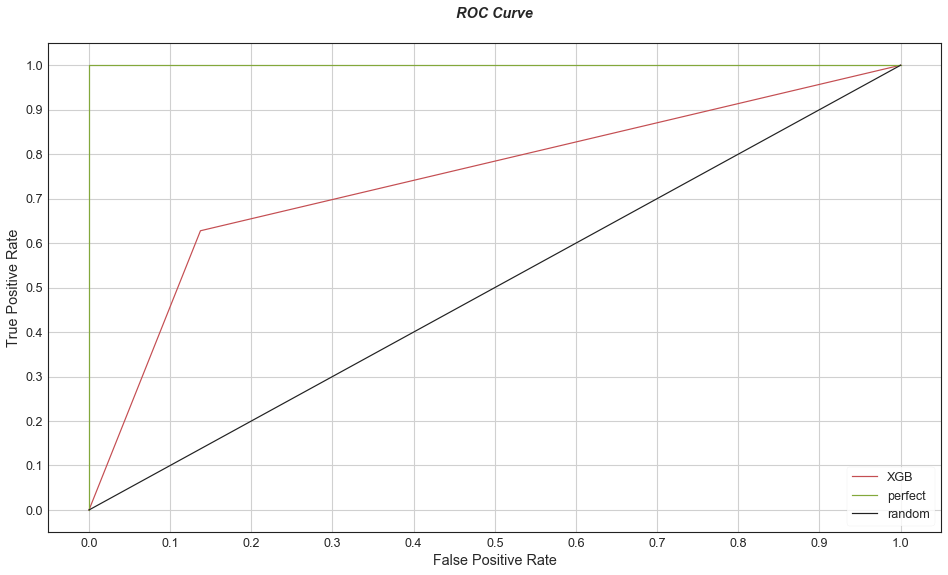

In [27]:
# Fitting xgboost model
xgb_churn =xgb.XGBClassifier(objective = 'binary:logistic', random_state = 555)
xgb_churn.fit(x_train_smote, y_train_smote)

# Predict test set
y_test_pred_xgb = xgb_churn.predict(x_test.values)

# Calculate auc score
print('* AUC score:', round(roc_auc_score(y_test.values, y_test_pred_xgb), 3))
print('* Accuracy:', round(accuracy_score(y_test.values, y_test_pred_xgb), 3))

# Plot ROC curve
fpr_XGB, tpr_XGB, thresholds_XGB = roc_curve(y_test.values, y_test_pred_xgb)
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(fpr_XGB, tpr_XGB,'r-',label = 'XGB')
ax.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
ax.plot([0,1],[0,1],'k-',label='random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_title('ROC Curve', 
                pad = 25, fontweight = 'bold', fontstyle = 'italic');
ax.grid(color =  '#D0D0D0')
for spine in ax.spines:
    ax.spines[spine].set_color('k') # Plot black border
plt.legend()
plt.show()

[Back to Table of Content](#TOC)

# 8. Concluding Remarks<a id = '8'></a>

* Univariate selection (chi-squared) was used to reduce number of features from 26 to 24.
* In order to counter the imbalanced dataset issue, the Synthetic Minority Oversampling Technique (SMOTE) technique was used to oversample the minority class in the train set.
* An XGBoost model was fitted to the training set. The AUC score was 0.75 with an accuracy of 80%.

[Back to Table of Content](#TOC)